In [2]:
#install required libraries
!pip install langchain langgraph langsmith langchain-groq langchain-tavily

INFO: pip is looking at multiple versions of langchain-groq to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_groq-1.0.0-py3-none-any.whl.metadata (1.7 kB)
  Attempting uninstall: langchain-groq
    Found existing installation: langchain-groq 0.3.8
    Uninstalling langchain-groq-0.3.8:
      Successfully uninstalled langchain-groq-0.3.8


In [3]:
# import the api key
groq_api_key = "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"

In [4]:
#import required libraries
from langgraph.graph import StateGraph, START, END
from functools import partial
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

In [14]:
# Define a state class
class State(TypedDict):
  message: Annotated[list, add_messages]

search_tool = TavilySearch(max_results=3, tavily_api_key="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")

@tool
def multiply(a: int, b: int) -> int:
  """ This function is responsible for multiplication """
  return a * b

@tool
def sumX(a: int, b: int) -> int:
  """ This function is responsible for summation """
  return a + b

In [15]:
search_tool.invoke({"query": "What is langchain?"})

{'query': 'What is langchain?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://aws.amazon.com/what-is/langchain/',
   'title': 'What is LangChain? - Amazon AWS',
   'content': 'LangChain is an open source framework for building applications based on large language models (LLMs). For example, developers can use LangChain components to build new prompt chains or customize existing templates. LangChain provides AI developers with tools to connect language models with external data sources. With LangChain, developers can adapt a language model flexibly to specific business contexts by designating steps required to produce the desired outcome. Developers then use the chain building blocks or LangChain Expression Language (LCEL) to compose chains with simple programming commands. Developers use tools and libraries that LangChain provides to compose and customize existing chains for complex applications. You can connect Amazon Kendra to LangChain, 

In [16]:
from langchain_groq import ChatGroq
#initialize LLM
llm = ChatGroq(model="llama3:8b", groq_api_key=groq_api_key)

In [17]:
tools = [search_tool, multiply, sumX]

llm_with_tool = llm.bind(tools=tools)

In [18]:
#LLM node define
def tool_calling_llm(state: State):
  response = llm_with_tool.invoke(state["message"])
  return response

In [19]:
# build AI Agent
graph_builder = StateGraph(State)
# add node with agent
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

# bind tools condition

tools_cond = partial(tools_condition, messages_key="messages")

#  add edges

graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges("tool_calling_llm", tools_cond)

graph_builder.add_edge("tools", END)
# bind the all stuff
graph = graph_builder.compile()

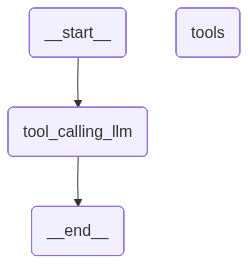

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
graph.invoke({"messages":[HumanMessage(content="please multiply 2 and 3")]})

PydanticSerializationError: Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>

In [23]:
# Tool Calling

#  name -> description -> args -> functionalities
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """This function is responsible for multiplication"""
    return a * b


@tool
def sumX(a: int, b: int) -> int:
    """This function is responsible for sum"""
    return a + b

In [25]:
multiply.invoke({'a':4, 'b':3})

12

In [26]:
multiply.name

'multiply'

In [27]:
multiply.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}